In [204]:
import numpy as np
import glob, os, sys
import copy
import pandas as pd
import datetime
from itertools import chain
from scipy.stats import pearsonr 

In [2]:
def show_progress_bar(iteration, total, prefix='', suffix='', length=50, fill='█'):
    """
    Display a progress bar in the terminal.

    Parameters:
    - iteration (int): Current iteration (starting from 0).
    - total (int): Total number of iterations.
    - prefix (str): Prefix string (e.g., 'Progress:').
    - suffix (str): Suffix string (e.g., 'Complete').
    - length (int): Character length of the progress bar.
    - fill (str): Character to represent progress.
    """
    iteration += 1
    percent = f"{100 * (iteration / float(total)):.1f}"  # Calculate progress percentage
    filled_length = int(length * iteration // total)    # Calculate the filled length
    bar = fill * filled_length + '-' * (length - filled_length)  # Construct the bar
    # Print the bar
    sys.stdout.write(f'\r{prefix} |{bar}| {percent}% {suffix}')
    sys.stdout.flush()
    # Print a new line when the process is complete
    if iteration == total:
        print()

In [3]:
def read_correct_dates(rmm_file_name):
    nanalysis2write = 40
    nforecasts = 7
    date = os.path.basename(rmm_file_name).split('.')[2]
    df = pd.read_csv(rmm_file_name)

    # Define the 40th date
    target_date = pd.to_datetime(date, format="%Y%m%d")
    
    # Generate 47 continuous dates ensuring 40th element is "20240706"
    date_range = pd.date_range(start=target_date - pd.Timedelta(days=nanalysis2write-1), periods=nanalysis2write+nforecasts, freq="D")
    
    # Convert to YYYYMMDD format
    date_list = date_range.strftime("%Y%m%d").tolist()
    # Extract year, month, and day from date_list
    df["year"] = [int(date[:4]) for date in date_list]
    df["month"] = [int(date[4:6]) for date in date_list]
    df["day"] = [int(date[6:]) for date in date_list]
    
    # Convert 'year', 'month', 'day' to datetime (keep as datetime, not string)
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    return df
    

In [4]:
date = datetime.datetime(2024, 12, 1)
date_label = date.strftime("%Y%m%d")
date_label

'20241201'

In [9]:
# Generate date range from 2023-09-01 to 2025-03-10
date_range = pd.date_range(start="2025-03-01", end="2025-03-10", freq="D")
date_range

DatetimeIndex(['2025-03-01', '2025-03-02', '2025-03-03', '2025-03-04',
               '2025-03-05', '2025-03-06', '2025-03-07', '2025-03-08',
               '2025-03-09', '2025-03-10'],
              dtype='datetime64[ns]', freq='D')

In [10]:
data_dir = "/data/users/prince.xavier/SALMON/processed_SEA_data/mogreps/mjo/rmms/"
mogreps_mjo_archive_dir = os.path.join(data_dir, date_label)
mogreps_mjo_archive_dir

'/data/users/prince.xavier/SALMON/processed_SEA_data/mogreps/mjo/rmms/20241201'

In [171]:
rmm_file_names = [glob.glob(os.path.join(data_dir, f'{datel.strftime("%Y%m%d")}/createdPCs.15sn.{datel.strftime("%Y%m%d")}.fcast.*.txt')) for datel in date_range]
rmm_file_names = list(chain.from_iterable(rmm_file_names))
len(rmm_file_names)

360

In [173]:
rmm_file_names.sort()
#rmm_file_names = rmm_file_names[:2]
len(rmm_file_names)

360

In [174]:
file = rmm_file_names[0]
file

'/data/users/prince.xavier/SALMON/processed_SEA_data/mogreps/mjo/rmms/20250301/createdPCs.15sn.20250301.fcast.000.txt'

In [175]:
# Initialize an empty list to store DataFrames
all_analysis_dfs = []
all_fcast_dfs = []
# Loop through each file
for i, file in enumerate(rmm_file_names):
    show_progress_bar(i, len(rmm_file_names))
    try:
        df = read_correct_dates(file)
        # Filter forecast data
        fcast_df = df.loc[df['label'] == 'forecast'].copy()  # Use .copy() to avoid SettingWithCopyWarning
        # Add lead column
        fcast_df['lead'] = range(1, len(fcast_df) + 1)  
        #     Add member column
        fcast_df['member'] = [int(file.split('.')[-2]) for i in range(len(fcast_df))]  
        # Append to list
        all_fcast_dfs.append(fcast_df)
    except:
        print(f'Problem in {file}')
        pass
print(len([df for df in all_analysis_dfs if df.empty]))
all_fcast_dfs = pd.concat(all_fcast_dfs, ignore_index=True)

 |██████████████████████████████████████████████████| 100.0% 
0


In [236]:
# Matching rows
matched_fc_dfs = []
matched_an_dfs = []
for i, row in all_fcast_dfs.iterrows():
    show_progress_bar(i, len(all_fcast_dfs))
    an_date = row.date# - pd.Timedelta(days=row.lead)
    try:
        #print(f'{row.date} - {row.lead} => {an_date}')
        an_file = os.path.join(data_dir, f'{an_date.strftime("%Y%m%d")}/createdPCs.15sn.{an_date.strftime("%Y%m%d")}.fcast.000.txt')
        df = read_correct_dates(an_file)
        # Filter forecast data
        an_df = df.loc[(df['label'] == 'analysis') & (df['date']==an_date)].copy()  # Use .copy() to avoid SettingWithCopyWarning
        an_df['lead'] = row.lead
        an_df['member'] = row.member
        
        matched_an_dfs.append(an_df)
        # This is needed because row comes as an array rather than dataframe
        matched_fc_dfs.append(pd.DataFrame(row).T)
    except:
        print(f'no matches were found for {row.date} {row.lead}')


matched_fc_dfs = pd.concat(matched_fc_dfs, ignore_index=True)
matched_an_dfs = pd.concat(matched_an_dfs, ignore_index=True)
len(matched_an_dfs), len(matched_fc_dfs)

 |██████████████████████████████████████████████████| 100.0% 


(2520, 2520)

In [257]:
leads = range(1, 8)
corr = []
for lead in leads:
    ans = matched_an_dfs.loc[(matched_an_dfs.lead==lead)]
    fcs = matched_fc_dfs.loc[(matched_fc_dfs.lead==lead)]

    corr.append(pearsonr(np.array(ans.rmm1), np.array(fcs.rmm1).astype('float64')).statistic)

(0.0, 1.0)

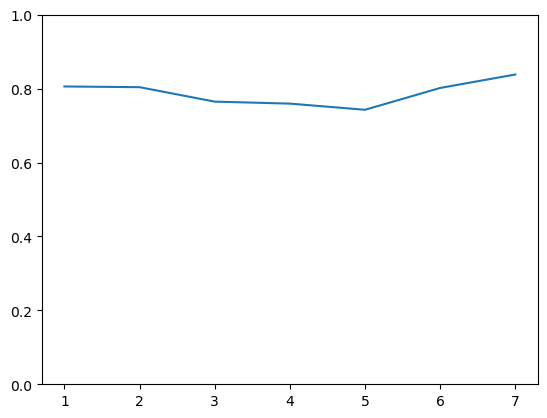

In [258]:
plt.plot(leads, corr)
plt.ylim([0, 1])

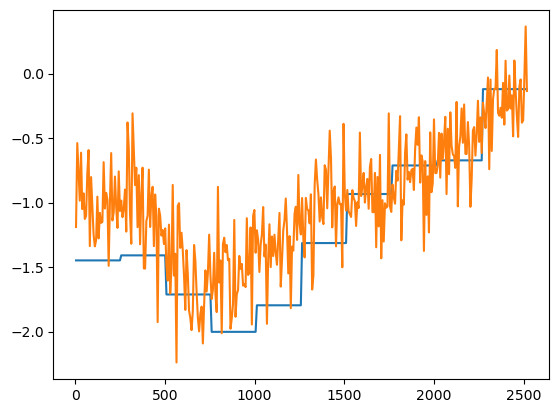

In [207]:
import matplotlib.pyplot as plt
plt.plot(ans.rmm1)
plt.plot(fcs.rmm1)

In [224]:
pearsonr(np.array(ans.rmm1), np.array(fcs.rmm1).astype('float64'))
#np.array(ans.rmm1).dtype, 

PearsonRResult(statistic=0.8017219568586287, pvalue=5.0150156738938535e-82)

In [189]:
# Merge on 'lead' and a suitable index (e.g. time or forecast ID) if needed
# If rows are already aligned, you can skip merging and just group
merged = pd.merge(
    matched_an_dfs[['lead', 'rmm1']], 
    matched_fc_dfs[['lead', 'rmm1']], 
    on='lead', 
    suffixes=('_ans', '_fcs')
)
merged

,lead,rmm1_ans,rmm1_fcs
0,1,-1.445295,-1.286383
1,1,-1.445295,-1.195706
2,1,-1.445295,-1.290706
3,1,-1.445295,-1.438716
4,1,-1.445295,-1.438315
...,...,...,...
907195,7,0.397550,-0.248131
907196,7,0.397550,-0.276252
907197,7,0.397550,0.004219
907198,7,0.397550,0.692396


In [190]:
# Group by 'lead' and calculate correlation for each group
correlations = (
    merged.groupby('lead')
          .apply(lambda g: g['rmm1_ans'].corr(g['rmm1_fcs']))
          .reset_index(name='correlation')
)

print(correlations)

   lead   correlation
0     1  8.571856e-18
1     2 -3.437160e-17
2     3 -2.360026e-17
3     4 -2.753544e-17
4     5  5.450328e-17
5     6 -1.034992e-18
6     7  1.134964e-17


/var/tmp/ipykernel_680730/1587963888.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g['rmm1_ans'].corr(g['rmm1_fcs']))


In [65]:
all_analysis_dfs = all_analysis_dfs.drop_duplicates(subset=['date'], keep='first').reset_index(drop=True)

In [66]:
len(all_analysis_dfs), len(all_fcast_dfs)

(49, 2520)

In [85]:
all_analysis_dfs.loc[all_analysis_dfs.date == '2025-03-02']

,year,month,day,rmm1,rmm2,phase,amp,label,date,member
40,2025,3,2,-1.445295,-0.711093,1,1.610755,analysis,2025-03-02,0


In [86]:
all_analysis_dfs.iloc

,year,month,day,rmm1,rmm2,phase,amp,label,date,member
0,2025,1,21,1.204735,-1.866465,3,2.221503,analysis,2025-01-21,0
1,2025,1,22,1.477719,-1.929746,3,2.430550,analysis,2025-01-22,0
2,2025,1,23,1.683742,-1.710804,3,2.400383,analysis,2025-01-23,0
3,2025,1,24,1.862796,-1.278963,4,2.259592,analysis,2025-01-24,0
4,2025,1,25,1.987425,-0.967386,4,2.210360,analysis,2025-01-25,0
5,2025,1,26,2.237143,-0.737967,4,2.355717,analysis,2025-01-26,0
6,2025,1,27,2.214496,-0.771308,4,2.344975,analysis,2025-01-27,0
7,2025,1,28,1.897290,-0.506083,4,1.963626,analysis,2025-01-28,0
8,2025,1,29,1.981099,-0.103912,4,1.983822,analysis,2025-01-29,0
9,2025,1,30,2.239351,0.086538,5,2.241023,analysis,2025-01-30,0


In [87]:
all_fcast_dfs.iloc[:10]

,year,month,day,rmm1,rmm2,phase,amp,label,date,lead,member
0,2025,3,2,-1.286383,-0.659823,1,1.445734,forecast,2025-03-02,1,0
1,2025,3,3,-1.338697,-0.866843,1,1.594844,forecast,2025-03-03,2,0
2,2025,3,4,-1.492709,-1.205252,1,1.918545,forecast,2025-03-04,3,0
3,2025,3,5,-1.576248,-1.280175,1,2.030617,forecast,2025-03-05,4,0
4,2025,3,6,-1.324730,-1.165891,1,1.764712,forecast,2025-03-06,5,0
5,2025,3,7,-1.189727,-1.198143,2,1.688489,forecast,2025-03-07,6,0
6,2025,3,8,-1.190348,-1.233312,2,1.714056,forecast,2025-03-08,7,0
7,2025,3,2,-1.195706,-0.794365,1,1.435524,forecast,2025-03-02,1,1
8,2025,3,3,-1.105614,-0.917713,1,1.436865,forecast,2025-03-03,2,1
9,2025,3,4,-1.211967,-1.060566,1,1.610485,forecast,2025-03-04,3,1


In [88]:
# Filter all_analysis_dfs to keep only rows where 'date' exists in fc_dfs['date']
lead_time = 4
fc_dfs = all_fcast_dfs.loc[(all_fcast_dfs.lead == lead_time)]
print(len(fc_dfs))
matched_analysis_df = []
matched_forecast_df = []
cols = all_analysis_dfs.columns
for index, row in fc_dfs.iterrows():
    #print(row.date, row.amp)
    try:
        m_an_df = all_analysis_dfs.loc[all_analysis_dfs['date'] == row['date']]
        m_fc_df = all_fcast_dfs.loc[all_fcast_dfs['date'] == row['date']]
    except:
        pass
    matched_analysis_df.append(m_an_df)
    matched_forecast_df.append(m_fc_df)
    
    
print(len(matched_analysis_df), len(matched_forecast_df))

360
360 360


In [89]:
matched_analysis_df = pd.concat(matched_analysis_df)
matched_forecast_df = pd.concat(matched_forecast_df)

In [90]:
len(matched_analysis_df), len(matched_forecast_df)

(216, 75168)

In [93]:
len(matched_forecast_df.loc[ (matched_forecast_df.member==0) & (matched_forecast_df.lead==1)])

252

In [94]:
matched_analysis_df.loc[ (matched_analysis_df.member==0) & (matched_analysis_df.lead==1)]

AttributeError: 'DataFrame' object has no attribute 'lead'

In [36]:
len(pd.concat(matched_analysis_df, ignore_index=True))

/var/tmp/ipykernel_680730/2151696424.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  len(pd.concat(matched_analysis_df, ignore_index=True))


216

In [37]:
len(matched_analysis_df), len(fc_dfs)
#matched_analysis_df.iloc[10], fc_dfs.iloc[10]

(360, 360)

In [38]:
# day 3 forecast
t = 2
fc_data = fcast_df.iloc[t]
fc_date = pd.to_datetime(fc_data['date'])
fc_data

year                     2025
month                       3
day                        13
rmm1                -0.869248
rmm2                -1.569182
phase                       2
amp                  1.793858
label                forecast
date      2025-03-13 00:00:00
lead                        3
member                     35
Name: 42, dtype: object

In [111]:
an_file_name = glob.glob(os.path.join(data_dir, fc_date.strftime('%Y%m%d'), '*.txt'))[0]
an_file_name
adf = pd.read_csv(an_file_name)
adf['date'] = pd.to_datetime(adf[['year', 'month', 'day']]).dt.strftime('%Y-%m-%d')

In [112]:
adf.loc[pd.to_datetime(adf['date'], format='%Y-%m-%d') == pd.to_datetime(fc_date, format='%Y-%m-%d')]

,year,month,day,rmm1,rmm2,phase,amp,label,date
39,2024,12,3,2.453316,0.843059,5,2.59413,analysis,2024-12-03
